In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn_extra.cluster import KMedoids
from sklearn.feature_extraction.text import CountVectorizer
from data_parsing import DataParser
import seaborn as sb
import os
import scipy.sparse

### sb seaborn library sets the aesthetic for the charts with seaborn library

### comment out either AM or LaaL depending on what you want to run.  Make sure to use correct csv data files for subsequent analysis

In [2]:
sb.set(context='notebook', style='white', palette='deep', font='Times', font_scale=1, color_codes=True, rc=None)

## AM dataset
dataAM = DataParser('course_data/MITxPRO+AMxB+1T2018/edges', 'course_data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')

## LaaL dataset
# dataLaaL = DataParser('course_data/MITxPRO+LASERxB1+1T2019/LaaL', 'course_data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')

In [3]:

trajectories = dataAM.trajectories

## LaaL dataset
# trajectories = dataLaaL.trajectories

In [4]:
vectorizer = CountVectorizer(ngram_range=[2,2])
url_counts = vectorizer.fit_transform(list(trajectories.apply(lambda x : " ".join([str(url) for url in x]))))
len(vectorizer.get_feature_names())

31648

In [10]:
def get_medoid_clusters(k, url_subset, traj_subset):
    kmedoids = KMedoids(n_clusters = k).fit(url_subset)
    kmedoids.labels_
    
    labels = pd.DataFrame(kmedoids.labels_)
    labels['index'] = traj_subset.index
    labels['is exemplar'] = 0
    for exemplar in kmedoids.medoid_indices_:
        labels.iloc[exemplar, 2] = 1
    #labels.to_csv('MITxPRO+LASERxB1+1T2019_kmedoids {} clusters.csv'.format(k), header = ['cluster id', 'user id', 
                                                                                     #'is exemplar'], index = False)  
    clusters = []
    cluster_id = []
    cluster_len = []
    for i in range(k):
        clusters.append([])
        cluster_id.append([])
        cluster_len.append([])
        
    for i, label in enumerate(kmedoids.labels_):
        clusters[label].append(traj_subset.index[i])
        cluster_id[label].append(i)
        cluster_len[label].append(len(traj_subset.iloc[i]))
    #print([np.mean(x) for x in cluster_len])
    return cluster_id

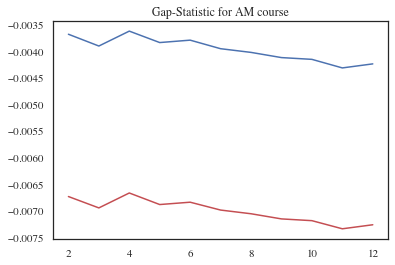

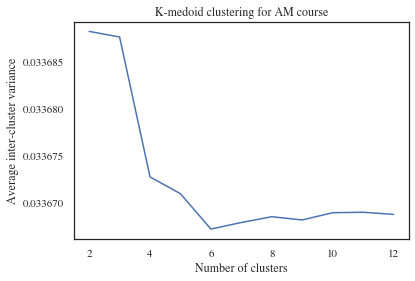

In [18]:
b = 10
x = trajectories
subset_len = int(np.floor(len(x)/b))
index = np.arange(url_counts.shape[0])
np.random.shuffle(index)

gaps = []
w_history = []
stds = []
ks = [2,3,4,5,6,7,8,9,10,11,12]
for k in ks:
    ## print('\n\t', k)
    # Calculating intercluster variance for each subset, W_kB
    W_kb = [] 
    for i in range(b):
        ii = index[i*subset_len: (i+1)*subset_len]
        url_subset = url_counts[ii]
        traj_subset = trajectories.iloc[ii]
        
        cluster_id = get_medoid_clusters(k, url_subset, traj_subset)
        cluster_variances = []
        for i in range(k):
            cluster_variances.append(url_subset.todense()[cluster_id[i]].var())
        cluster_variances = np.array(cluster_variances)
        cluster_counts = np.array([len(x) for x in cluster_id])
        W_kb.append((cluster_variances*cluster_counts/subset_len).sum())

    W_kb = np.array(W_kb)
        
    # Calculating intercluster variance of full dataset, W_k
    cluster_id = get_medoid_clusters(k, url_counts, trajectories)
    cluster_variances = []
    for i in range(k):
        cluster_variances.append(url_counts.todense()[cluster_id[i]].var())
    cluster_variances = np.array(cluster_variances)
    cluster_counts = np.array([len(x) for x in cluster_id])
    W_k = (cluster_variances*cluster_counts/len(trajectories)).sum()
    w_history.append(W_k)

    # Final Calculations
    gap_k = 1/b * np.sum(np.log(W_kb)-np.log(W_k))
    std_k = np.std(W_kb) 
    gaps.append(gap_k)
    stds.append(std_k)
    #print(gap_k, std_k)

plt.title('Gap-Statistic for AM course')   
plt.plot(ks, gaps, "-b")
plt.plot(ks, np.array(gaps)-np.array(stds), "-r")
# plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

# plt.plot(ks, gaps)
# plt.plot(ks, np.array(gaps)-np.array(stds))
plt.show()
plt.xlabel('Number of clusters')
plt.ylabel('Average inter-cluster variance')
plt.title('K-medoid clustering for AM course')
plt.plot(ks, w_history)